In [ ]:
!pip install pyDOE

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from google.colab import files
from pyDOE import lhs
from scipy.fftpack import diff, fft, ifft
from scipy.integrate import odeint

import time

In [ ]:
# Boundaries of the computational domain
xleft, xright = -5000, 5000
t0, tfinal = 0, 1345.7104

# Gravitational constant
g = 9.81

### Subclassing layers

In [ ]:
# Define the normalization layer
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    return (inputs-self.xmin)/(self.xmax-self.xmin)

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [ ]:
# Scales of the problem
U = 5.0
H = 20
T = tfinal

# Bottom topography
h0c = 10
a = 3000
B = 5

# Initial conditions
omega = tf.sqrt(2*g*h0c)/a
z0 = lambda x: h0c*(x/a)**2
hh0 = lambda x: h0c - B**2/4/g*(1 + tf.cos(2*omega*t0)) - B*x/2/a*tf.sqrt(8*h0c/g)*tf.cos(omega*t0)
uu0 = lambda x: B*a*omega/tf.sqrt(2*h0c*g)*tf.sin(omega*t0) + 0*x

h0 = lambda x: tf.math.maximum(hh0(x), z0(x)) - z0(x)
u0 = lambda x: uu0(x)

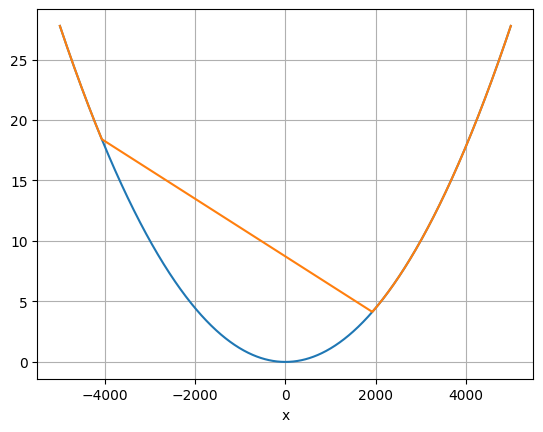

In [ ]:
x = np.linspace(xleft, xright, 1000).astype(np.float32)
plt.plot(x, z0(x))
plt.plot(x, h0(x)+z0(x))
plt.xlabel('x')
plt.grid()

In [ ]:
def build_model(n_units=40, n_layers=4):

  # Define the network
  inp1 = tf.keras.layers.Input(shape=(1,))
  b1 = Normalize(t0, tfinal)(inp1)

  inp2 = tf.keras.layers.Input(shape=(1,))
  b2 = Normalize(xleft, xright)(inp2)
  b = tf.keras.layers.Concatenate()([b1, b2])

  for i in range(n_layers):
    b = tf.keras.layers.Dense(n_units, activation='tanh')(b)
  u = tf.keras.layers.Dense(1, activation='linear')(b)
  h = tf.keras.layers.Dense(1, activation='linear')(b)
  # u = tf.keras.layers.Lambda(lambda x: tf.where(x[0]>=0, x[1], 0.0))([h, u])

  model = tf.keras.models.Model([inp1, inp2], [u, h])

  return model

In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 normalize_1 (Normalize)     (None, 1)                    0         ['input_1[0][0]']             
                                                                                                  
 normalize_3 (Normalize)     (None, 1)                    0         ['input_2[0][0]']             
                                                                                              

In [ ]:
def defineCollocationPoints(t_bdry, x_bdry, N_pde=10000, N_ic=100):

  # Convert input to numpy array
  t_bdry, x_bdry = np.array(t_bdry), np.array(x_bdry)

  # Uniform random sampling for PDE points
  tx_min = np.array([t_bdry[0], x_bdry[0]])
  tx_max = np.array([t_bdry[1], x_bdry[1]])
  pde_points = tx_min + (tx_max - tx_min)*lhs(2, N_pde)
  t_pde = pde_points[:, 0]
  x_pde = pde_points[:, 1]

  # Stack all the PDE point data together
  pdes = np.column_stack([t_pde, x_pde]).astype(np.float32)

  # Sample points where to evaluate the initial values
  init_points = tx_min[1:] + (tx_max[1:] - tx_min[1:])*lhs(1, N_ic)
  x_init = init_points
  t_init = t_bdry[0]+ 0.0*x_init
  u_init = u0(x_init)
  h_init = h0(x_init)
  inits = np.column_stack([t_init, x_init, u_init, h_init]).astype(np.float32)

  return pdes, inits

In [ ]:
@tf.function
def trainStep(pdes, ics, model):

  t, x = pdes[:,:1], pdes[:,1:2]
  ti, xi, ui, hi = ics[:,:1], ics[:,1:2], ics[:,2:3], ics[:,3:4]

  # Outer gradient for tuning network parameters
  with tf.GradientTape() as tape:

    # # Inner gradient for derivatives of u wrt x and t
    with tf.GradientTape(persistent=True) as tape1:
      tape1.watch(t), tape1.watch(x)
      [u, h] = model([t, x])
      z = z0(x)
      hu = h*u
      flux = h*u**2 + 0.5*g*h**2

    # Required derivatives
    ht = tape1.gradient(h, t)
    fluxx = tape1.gradient(flux, x)
    zx = tape1.gradient(z, x)
    [hut, hux] = tape1.gradient(hu, [t, x])

    # Solve the shallow-water equations
    eqn1 = ht + hux
    eqn2 = hut + fluxx + g*h*zx

    # Define the PDE loss
    PDEloss = tf.reduce_mean((T/H*eqn1)**2 + (T/(H*U)*eqn2)**2)

    # Initial value loss
    [ui_pred, hi_pred] = model([ti, xi])
    ICloss = tf.reduce_mean((ui*hi-ui_pred*hi_pred)**2/(H*U)**2 + (hi-hi_pred)**2/H**2)
    # ICloss = tf.reduce_mean((ui-ui_pred)**2/U**2 + (hi-hi_pred)**2/H**2)

    loss = PDEloss + ICloss

  # Compute the gradient of the global loss wrt the model parameters
  grads = tape.gradient(loss, model.trainable_variables)

  return loss, grads

In [ ]:
def PINNtrain(pde_points, ic_points, epochs=1000):

  # Optimizer for the problem
  lr = tf.keras.optimizers.schedules.PolynomialDecay(1e-3, decay_steps=epochs,
                                                     end_learning_rate=1e-3)
  opt = tf.keras.optimizers.Adam(lr)

  # Number of collocation points
  nr_pde_points = len(pde_points)
  nr_ic_points = len(ic_points)

  # Batch sizes
  batch_factor = 10
  bs_pde = nr_pde_points//(batch_factor)
  bs_ics = nr_ic_points//(batch_factor)

  # Epoch loss initialization
  epoch_loss = np.zeros(epochs)

  # tf dataset for collocation points
  ds_pde = tf.data.Dataset.from_tensor_slices(pde_points)
  ds_pde = ds_pde.shuffle(nr_pde_points).batch(bs_pde)

  ds_init = tf.data.Dataset.from_tensor_slices(ic_points)
  ds_init = ds_init.cache().shuffle(nr_ic_points).batch(bs_ics)

  # Combine the datasets
  ds = tf.data.Dataset.zip((ds_pde, ds_init))

  # Main training loop
  for i in range(epochs):

    nr_batches = 0

    # Train the model
    for (pdes, ics) in ds:

      # Train the network
      loss, grads = trainStep(pdes, ics, model)

      # Gradient step
      opt.apply_gradients(zip(grads, model.trainable_variables))

      epoch_loss[i] += loss
      nr_batches += 1

    epoch_loss[i] /= nr_batches

    if (np.mod(i, 100)==0):
      print(f"Total loss in {i}th epoch: { epoch_loss[i]: 6.4f}")

  return epoch_loss

In [ ]:
N_pde = 10000
N_ic = 100
pdes, ics = defineCollocationPoints([t0, tfinal], [xleft, xright], N_pde, N_ic)

In [ ]:
epochs = 5000
loss = PINNtrain(pdes, ics, epochs)

Total loss in 0th epoch:  0.0810
Total loss in 100th epoch:  0.0503
Total loss in 200th epoch:  0.0449
Total loss in 300th epoch:  0.0429
Total loss in 400th epoch:  0.0195
Total loss in 500th epoch:  0.0119
Total loss in 600th epoch:  0.0070
Total loss in 700th epoch:  0.0035
Total loss in 800th epoch:  0.0019
Total loss in 900th epoch:  0.0011
Total loss in 1000th epoch:  0.0008
Total loss in 1100th epoch:  0.0006
Total loss in 1200th epoch:  0.0005
Total loss in 1300th epoch:  0.0004
Total loss in 1400th epoch:  0.0004
Total loss in 1500th epoch:  0.0003
Total loss in 1600th epoch:  0.0003
Total loss in 1700th epoch:  0.0002
Total loss in 1800th epoch:  0.0003
Total loss in 1900th epoch:  0.0002
Total loss in 2000th epoch:  0.0003
Total loss in 2100th epoch:  0.0002
Total loss in 2200th epoch:  0.0003
Total loss in 2300th epoch:  0.0002
Total loss in 2400th epoch:  0.0002
Total loss in 2500th epoch:  0.0002
Total loss in 2600th epoch:  0.0002
Total loss in 2700th epoch:  0.0001
Tota

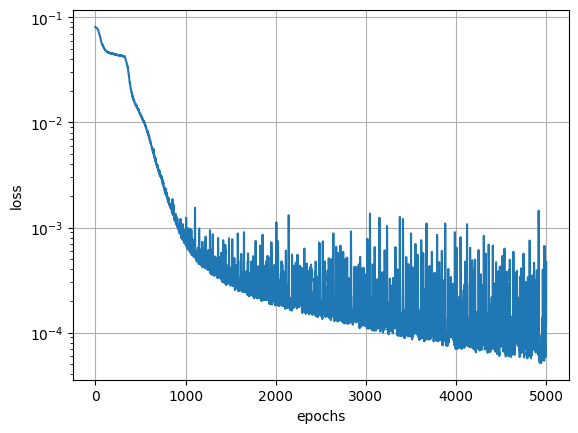

In [ ]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss.png')
plt.grid()

In [ ]:
# Grid where to evaluate the model
l, m = int(tfinal)+1, 200
t = np.linspace(t0, tfinal, l)
x = np.linspace(xleft, xright, m, endpoint=False)
TT, XX = np.meshgrid(t, x, indexing='ij')

# Evaluate the model
[u, h] = model([np.expand_dims(TT.flatten(), axis=1),
                np.expand_dims(XX.flatten(), axis=1)])

u = np.reshape(u, (l, m))
h = np.reshape(h, (l, m))
b = np.reshape(z0(XX.flatten()), (l, m))

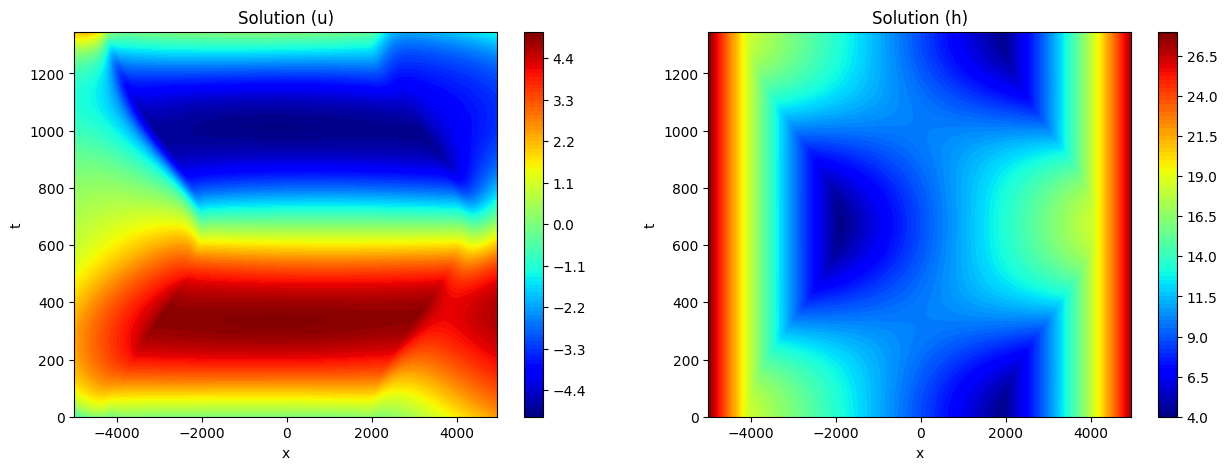

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.contourf(XX, TT, u, 100, cmap=plt.cm.jet)
plt.title('Solution (u)')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(122)
plt.contourf(XX, TT, h + b, 100, cmap=plt.cm.jet)
plt.title('Solution (h)')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

Text(0, 0.5, 'h+b')

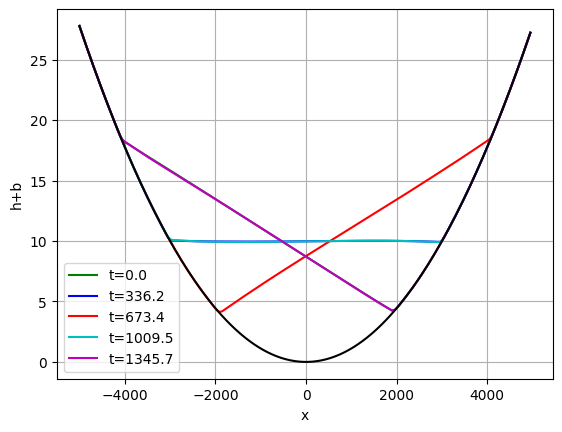

In [ ]:
nr = 5
steps = [i*len(h)//(nr-1) for i in range(nr)]
steps[-1] = -1
colors = ['g','b','r','c','m','y']

for c, p in zip(colors,steps):
  plt.plot(x, h[p,]+b[p,], color=c, label=f't={t[p]:.1f}')
plt.plot(x, b[p,],'k')
# plt.axis([1700, xright, H-10, H+20])
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('h+b')

In [ ]:
hexact = lambda t, x: h0c - B**2/4/g*(1 + tf.cos(2*omega*t)) - B*x/2/a*tf.sqrt(8*h0c/g)*tf.cos(omega*t)
htrue = lambda t, x: tf.math.maximum(hexact(t,x), z0(x)) - z0(x)

In [ ]:
hreference = htrue(TT, XX)

In [ ]:
print(steps)
print(t[steps])

[0, 336, 673, 1009, -1]
[   0.          336.17746796  673.35546409 1009.53293204 1345.7104    ]


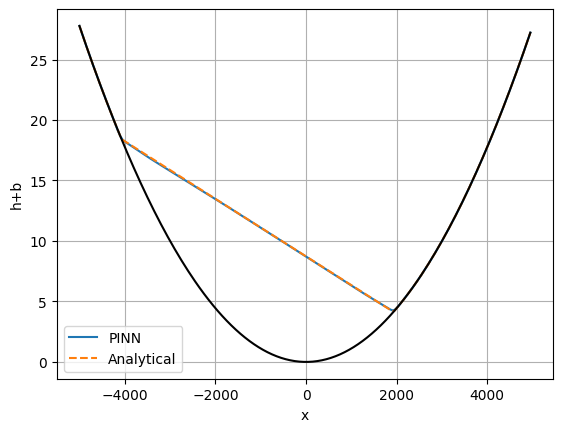

In [ ]:
p = -1
plt.plot(x, h[p,]+b[p,], label='PINN')
plt.plot(x, hreference[p,]+b[p,], '--', label='Analytical')

plt.plot(x, b[p,],'k')
# plt.axis([1700, xright, H-10, H+20])
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('h+b')
plt.savefig(f'Step{p}Bowl.png')

In [ ]:
p = 0
plt.plot(x, h[p,]+b[p,], label='PINN')
plt.plot(x, hreference[p,]+b[p,], '--', label='Analytical')

plt.plot(x, b[p,],'k')
# plt.axis([1700, xright, H-10, H+20])
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('h+b')
plt.savefig(f'Step{p}Bowl.png')

In [ ]:
err = np.linalg.norm(h-hreference, ord=2, axis=1)/np.linalg.norm(hreference+b, ord=2, axis=1)

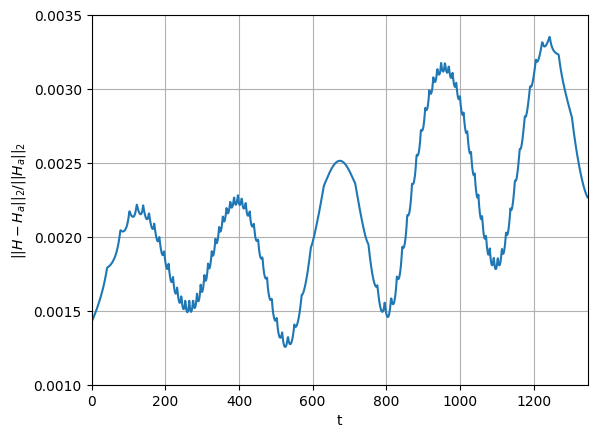

In [ ]:
plt.plot(t, err)
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$||H-H_a||_2/||H_a||_2$')
plt.axis([0.0, tfinal, 0.0010, 0.0035])
plt.savefig('errorBowlTimeSeries.png')

In [ ]:
mass = np.sum(h, axis=1)

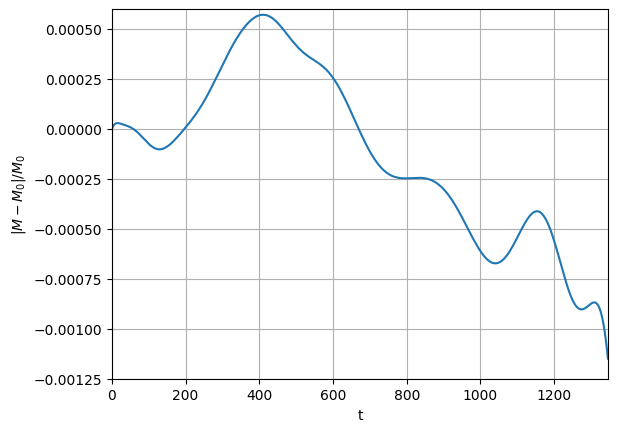

In [ ]:
plt.plot(t, (mass-mass[0])/mass[0])
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$|M-M_0|/M_0$')
plt.axis([0.0, tfinal, -0.00125, 0.00060])
plt.savefig('massTimeSeries.png')

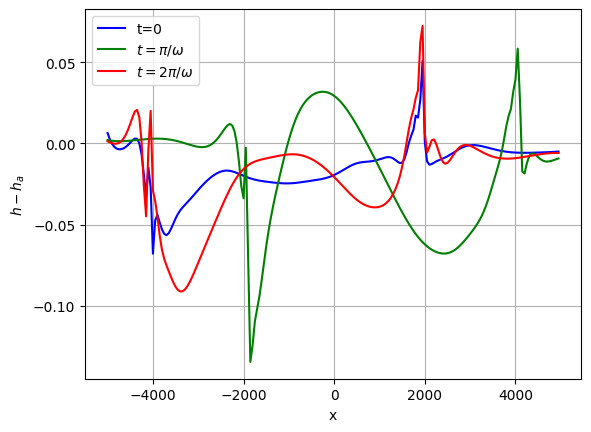

In [ ]:
nr = 3
steps = [i*len(h)//(nr-1) for i in range(nr)]
steps[-1] = -1
colors = ['b','g','r','c','m','y']
legends = ['t=0', r'$t=\pi/\omega$', r'$t=2\pi/\omega$']

for c, p, l in zip(colors,steps,legends):
  plt.plot(x, (h[p,]-hreference[p,]), color=c, label=l)
# plt.axis([1700, xright, H-10, H+20])
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$h-h_a$')
plt.savefig('errorBowl.png')